In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyStochastic = MdpKernel()
mdpPolicyStochastic.load_policy(mdpKernelParams, policyMode="stochastic")
mdpPolicyDeterministic = MdpKernel()
mdpPolicyDeterministic.load_policy(mdpKernelParams, policyMode="deterministic")

# ==== Prepare Simulator====
num_windows = 5000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyDeterministic, env)
simResultDeterministic = policySimulator.runSimulation(mdpPolicyDeterministic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
'''
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)
'''
policySimulator = PolicySimulator(mdpPolicyStochastic, env)
simResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultStochastic['uRecord'], simResultDeterministic['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultStochastic['uRecord'] + simResultDeterministic['uRecord'], 
    simResultStochastic['actionsRecord'] + simResultDeterministic['actionsRecord'], 
    simResultStochastic['rewardRecord'] + simResultDeterministic['rewardRecord'], 
    simResultStochastic['uNextRecord'] + simResultDeterministic['uNextRecord']
)


Simulation Progress: 100%|██████████| 5000/5000 [00:12<00:00, 396.91it/s, avg reward=0.007824]


In [4]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 5e-3,
    'eta': 0.05,
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env,
    clonePolicy=True,
    epochs=1000, 
    batch_size=512,
    updateCriticOnly=False)

Evaluation windows: 100%|██████████| 500/500 [00:13<00:00, 37.11it/s]                                         


Epoch  100/1000  Avg Ld=0.079205  Avg Lq=-4.660680  Avg loss_critic=0.015981  Test packet loss=0.0108


Evaluation windows: 100%|██████████| 500/500 [00:12<00:00, 40.93it/s]                                          


Epoch  200/1000  Avg Ld=0.041167  Avg Lq=-12.499387  Avg loss_critic=0.011816  Test packet loss=0.0078


Evaluation windows: 100%|██████████| 500/500 [00:13<00:00, 37.44it/s]                                          


Epoch  300/1000  Avg Ld=0.038402  Avg Lq=-19.779190  Avg loss_critic=0.021006  Test packet loss=0.0082


Evaluation windows: 100%|██████████| 500/500 [00:12<00:00, 39.57it/s]                                          


Epoch  400/1000  Avg Ld=0.037329  Avg Lq=-26.360943  Avg loss_critic=0.032859  Test packet loss=0.0080


Evaluation windows: 100%|██████████| 500/500 [00:12<00:00, 38.84it/s]                                          


Epoch  500/1000  Avg Ld=0.034955  Avg Lq=-32.185421  Avg loss_critic=0.061863  Test packet loss=0.0066


Evaluation windows: 100%|██████████| 500/500 [00:05<00:00, 94.46it/s]                                          


Epoch  600/1000  Avg Ld=0.032746  Avg Lq=-37.295364  Avg loss_critic=0.078482  Test packet loss=0.0063


Evaluation windows: 100%|██████████| 500/500 [00:05<00:00, 97.67it/s]                                          


Epoch  700/1000  Avg Ld=0.032296  Avg Lq=-41.757847  Avg loss_critic=0.096083  Test packet loss=0.0070


Evaluation windows: 100%|██████████| 500/500 [00:05<00:00, 94.78it/s]                                          


Epoch  800/1000  Avg Ld=0.032220  Avg Lq=-45.826519  Avg loss_critic=0.126713  Test packet loss=0.0065


Evaluation windows: 100%|██████████| 500/500 [00:05<00:00, 94.33it/s]                                          


Epoch  900/1000  Avg Ld=0.033445  Avg Lq=-49.386635  Avg loss_critic=0.131688  Test packet loss=0.0067


Evaluation windows: 100%|██████████| 500/500 [00:08<00:00, 61.46it/s]                                           

Epoch 1000/1000  Avg Ld=0.030531  Avg Lq=-52.594570  Avg loss_critic=0.151255  Test packet loss=0.0072


In [5]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl


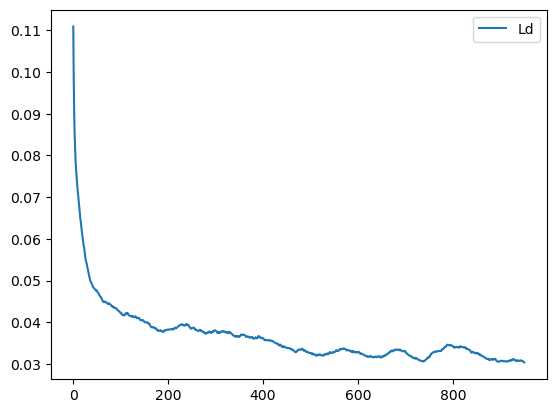

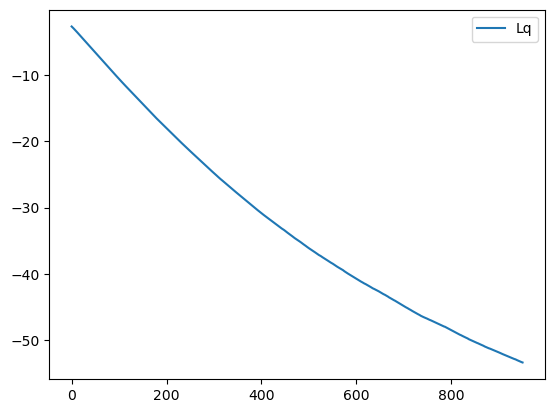

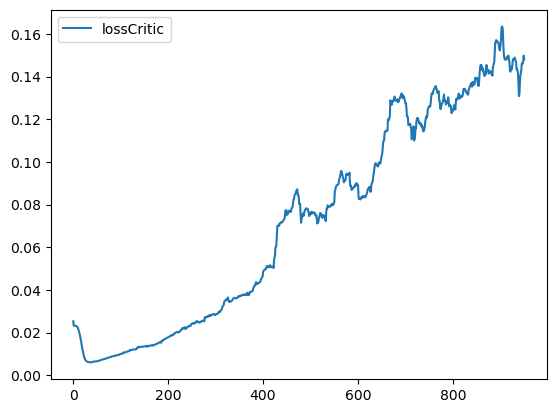

In [8]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 50
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()